**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from collections import defaultdict

In [2]:
df=pd.read_csv(r'../data/datatraining.txt')
test1=pd.read_csv(r'../data/datatest.txt')
test2=pd.read_csv(r'../data/datatest2.txt')
df=df.append(test1)
df=df.append(test2)

In [3]:
df['date'] =  pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S')
df['Time']= df['date'].apply(lambda x:x.time())
df['Date']= df['date'].apply(lambda x:x.date())
df['Time'] =  pd.to_timedelta(str(x) for x in df['Time'])
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop('date', axis=1, inplace=True)

df['time']=df['Time'].apply(lambda x:int(str(x)[7:9]+str(x)[10:12]))
#df['time'] = df['time'].astype(int)
df['Holiday'] = df['Date'].apply(lambda x: 0 if x.weekday()<5 else 1 )
df=df[df['Light']<1000]

print(df['Occupancy'].value_counts(normalize=True))
df['Occupancy'].value_counts()

0    0.769208
1    0.230792
Name: Occupancy, dtype: float64


0    15808
1     4743
Name: Occupancy, dtype: int64

In [4]:

df = df[df['Holiday']==0]                                            #TOLGO TUTTI I SABATI E LE DOMENICHE

df = df[df['time']<1825]                                             #TOLGO DOP LE 18:35

df = df[df['time']>735]                                              #TOLGO PRIMA DELLE 7:35                                       

df = df[df['Light']>388]                                             #TOLGO TUTTI CON MENO LUCE DI 380
print(df['Occupancy'].value_counts())
print(df['Occupancy'].value_counts(normalize=True))

1    4717
0     183
Name: Occupancy, dtype: int64
1    0.962653
0    0.037347
Name: Occupancy, dtype: float64


In [5]:
df.drop(['Date','time'],axis=1,inplace=True)

# Data Partitioning

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [7]:
from sklearn.model_selection import train_test_split
training, test = train_test_split(df[[col for col in df.columns]], test_size=0.3, random_state=100, stratify=df['Occupancy'])

In [8]:

attributes = ['Temperature', 'Humidity', 'Light', 'CO2', 'Holiday']

X_train =training[attributes].copy()
y_train=training['Occupancy'].values
X_test=test[attributes].copy()
y_test=test['Occupancy'].values

In [9]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array([0, 1], dtype=int64), array([ 128, 3302], dtype=int64)),
 (array([0, 1], dtype=int64), array([  55, 1415], dtype=int64)))

# Classification

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
clf = DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
clf.fit(X_train, y_train)

y_pred0 = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0))
print('F1-score %s' % f1_score(y_test, y_pred0, average=None))
print(classification_report(y_test, y_pred0))

Accuracy 0.964625850340136
F1-score [0.52727273 0.98162544]
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        55
           1       0.98      0.98      0.98      1415

    accuracy                           0.96      1470
   macro avg       0.75      0.75      0.75      1470
weighted avg       0.96      0.96      0.96      1470



In [12]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9761904761904762
F1-score [0.58823529 0.98774081]
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        55
           1       0.98      1.00      0.99      1415

    accuracy                           0.98      1470
   macro avg       0.91      0.73      0.79      1470
weighted avg       0.97      0.98      0.97      1470



# ROC curve

In [13]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [14]:
y_score = clf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

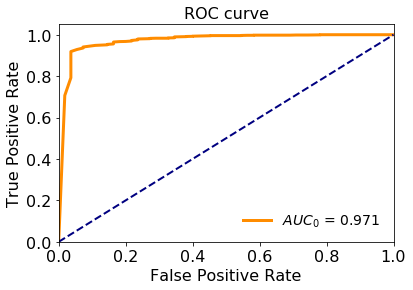

In [15]:

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Adjust the Decision Threshold

Accuracy 0.9414965986394558
F1-score [0.44871795 0.9691092 ]
              precision    recall  f1-score   support

           0       0.35      0.64      0.45        55
           1       0.99      0.95      0.97      1415

    accuracy                           0.94      1470
   macro avg       0.67      0.79      0.71      1470
weighted avg       0.96      0.94      0.95      1470



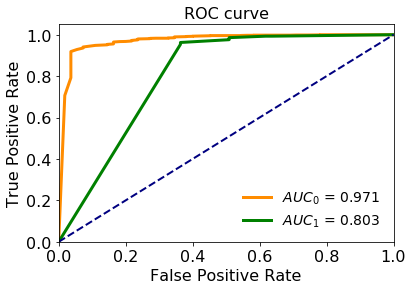

In [16]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

def adjusted_predict(X, thr=0.96):
    y_score = clf.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score])

y_pred = adjusted_predict(X_test, thr=0.96)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, thr = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# PCA

In [17]:
from sklearn.decomposition import PCA

In [18]:
X_train.shape

(3430, 5)

In [19]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_train)

In [20]:
X_pca.shape

(3430, 2)

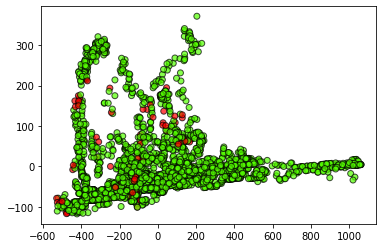

In [21]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

# Undersampling

In [22]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

Using Theano backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\carlo\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Resampled dataset shape Counter({0: 128, 1: 128})


KeyboardInterrupt: 

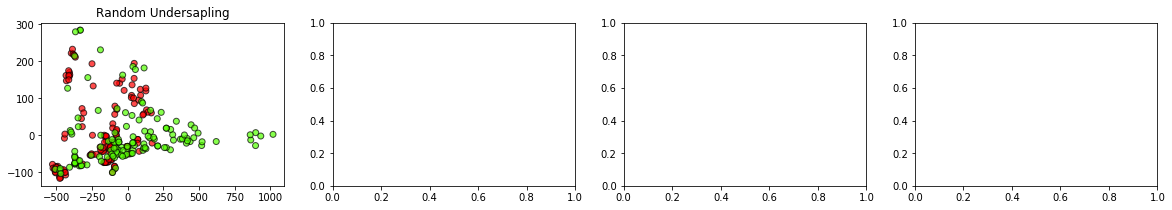

In [81]:
fig, axes = plt.subplots(1, 4, figsize=(20,3))

rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[0].set_title("Random Undersapling")

cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[1].set_title("Condensed Nearest Neighbour")

from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='majority')
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[2].set_title("Tomek Links")

from imblearn.under_sampling import OneSidedSelection #non funziona non si sa perche 
from imblearn.under_sampling import InstanceHardnessThreshold #neanche funziona
from imblearn.under_sampling import NearMiss
nm = InstanceHardnessThreshold(sampling_strategy=1)
X_res, y_res = nm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[3].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[3].set_title("Near Miss")


plt.show()

Resampled dataset shape Counter({1: 2646, 0: 128})


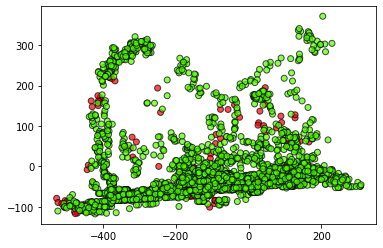

In [23]:
from imblearn.under_sampling import OneSidedSelection #non funziona non si sa perche 
from imblearn.under_sampling import InstanceHardnessThreshold
oss = OneSidedSelection(sampling_strategy='majority')
X_res, y_res = oss.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

### RandomUnderSampler

In [24]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 128, 1: 128})


In [25]:
print(len(X_res),len(X_test))

256 1470


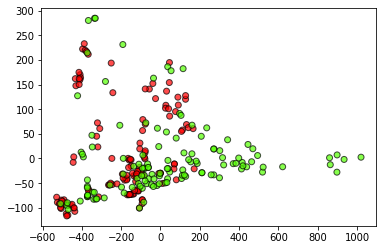

In [26]:

pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.7020408163265306
F1-score [0.19188192 0.81734779]
              precision    recall  f1-score   support

           0       0.11      0.95      0.19        55
           1       1.00      0.69      0.82      1415

    accuracy                           0.70      1470
   macro avg       0.55      0.82      0.50      1470
weighted avg       0.96      0.70      0.79      1470



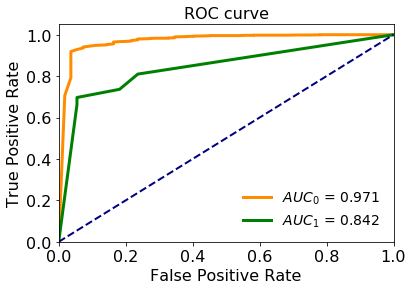

In [27]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.7925170068027211
F1-score [0.25061425 0.87958942]
              precision    recall  f1-score   support

           0       0.14      0.93      0.25        55
           1       1.00      0.79      0.88      1415

    accuracy                           0.79      1470
   macro avg       0.57      0.86      0.57      1470
weighted avg       0.96      0.79      0.86      1470



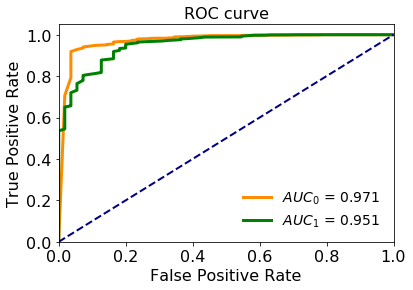

In [28]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [29]:
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_res, y_res, cv=5)

print('Accuracy %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Accuracy 0.840 +/- 0.058


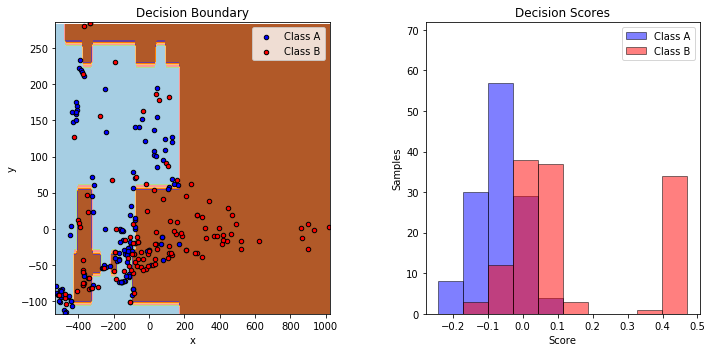

In [30]:
# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause
X=X_pca
y=y_res
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles



# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 10
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min()-1 , X[:, 0].max()+1 
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

### CondensedNearestNeighbour

In [128]:
import warnings
warnings.simplefilter("ignore")

In [129]:
cnn = CondensedNearestNeighbour(random_state=42, n_jobs=10)
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

KeyboardInterrupt: 

In [ ]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

estimators = [('rf',RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)),
                             ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))]
clf = StackingClassifier( estimators=estimators, final_estimator=MLPClassifier(random_state=0,solver= 'adam', learning_rate_init= 0.01, hidden_layer_sizes=(15)))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

## TomekLink

Resampled dataset shape Counter({1: 300, 0: 128})


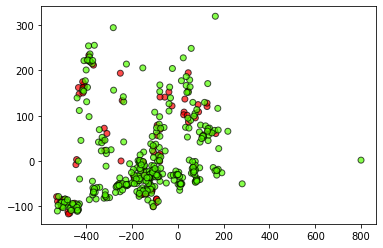

In [130]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_res, y_res = cnn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.8421768707482993
F1-score [0.22666667 0.91212121]
              precision    recall  f1-score   support

           0       0.14      0.62      0.23        55
           1       0.98      0.85      0.91      1415

    accuracy                           0.84      1470
   macro avg       0.56      0.73      0.57      1470
weighted avg       0.95      0.84      0.89      1470



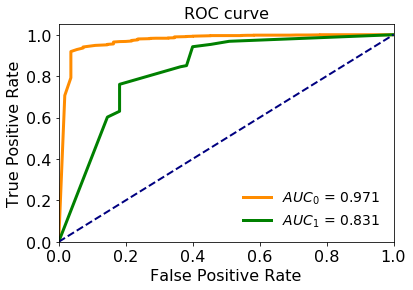

In [131]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9761904761904762
F1-score [0.58823529 0.98774081]
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        55
           1       0.98      1.00      0.99      1415

    accuracy                           0.98      1470
   macro avg       0.91      0.73      0.79      1470
weighted avg       0.97      0.98      0.97      1470



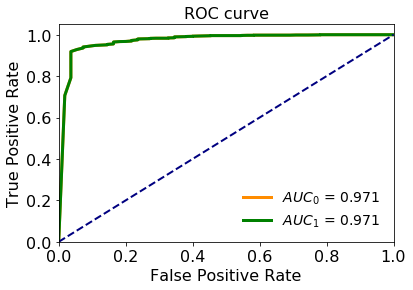

In [132]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

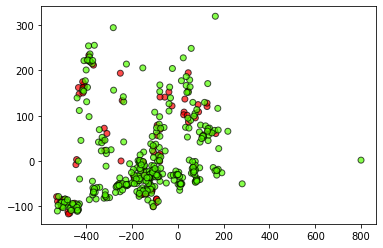

In [135]:

pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
X_test_pca = pca.transform(X_test)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9585034013605442
F1-score [0.3960396  0.97851356]
              precision    recall  f1-score   support

           0       0.43      0.36      0.40        55
           1       0.98      0.98      0.98      1415

    accuracy                           0.96      1470
   macro avg       0.71      0.67      0.69      1470
weighted avg       0.96      0.96      0.96      1470



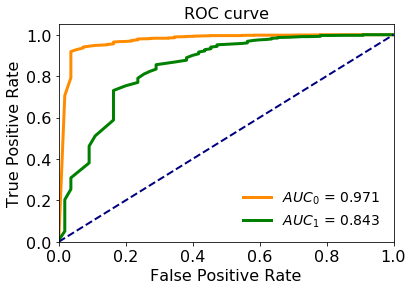

In [137]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)

clf.fit(X_pca, y_res)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

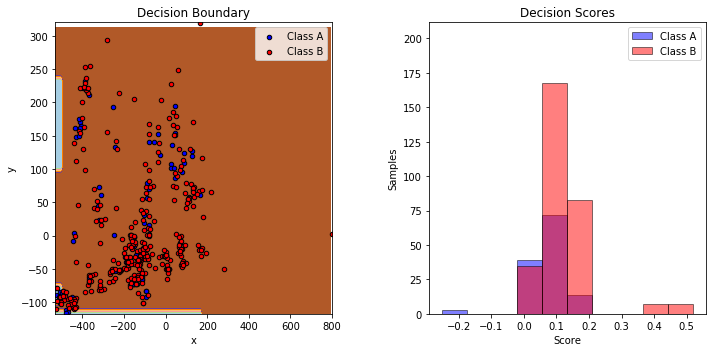

In [141]:
# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause
X=X_pca
y=y_res
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles



# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 10
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min()-1 , X[:, 0].max()+1 
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

# Oversampling

Resampled dataset shape Counter({1: 3302, 0: 3302})
Resampled dataset shape Counter({1: 3302, 0: 3302})
Resampled dataset shape Counter({1: 3302, 0: 3285})


NameError: name 'ksm' is not defined

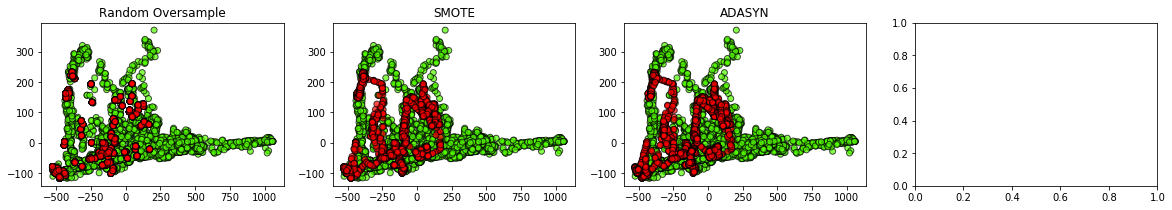

In [31]:
fig, axes = plt.subplots(1, 4, figsize=(20,3))

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[0].set_title('Random Oversample')

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[1].set_title('SMOTE')

from imblearn.over_sampling import ADASYN
adasyn  = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[2].set_title('ADASYN')

from imblearn.over_sampling import SVMSMOTE
svm  =SVMSMOTE()
X_res, y_res = ksm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)
axes[3].scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
axes[3].set_title('SVMSMOTE')

plt.show()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

### RandomOverSampler

In [44]:
ros = RandomOverSampler(random_state=42, sampling_strategy = 'minority')
X_res, y_res = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 3302, 0: 3302})


Accuracy 0.9680272108843537
F1-score [0.60504202 0.98333924]
              precision    recall  f1-score   support

           0       0.56      0.65      0.61        55
           1       0.99      0.98      0.98      1415

    accuracy                           0.97      1470
   macro avg       0.77      0.82      0.79      1470
weighted avg       0.97      0.97      0.97      1470



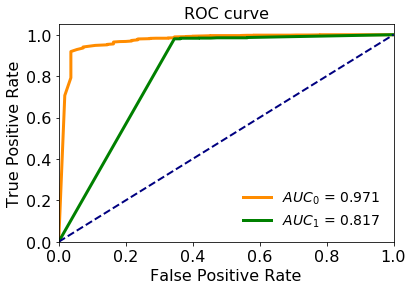

In [42]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9727891156462585
F1-score [0.65517241 0.98583569]
              precision    recall  f1-score   support

           0       0.62      0.69      0.66        55
           1       0.99      0.98      0.99      1415

    accuracy                           0.97      1470
   macro avg       0.81      0.84      0.82      1470
weighted avg       0.97      0.97      0.97      1470



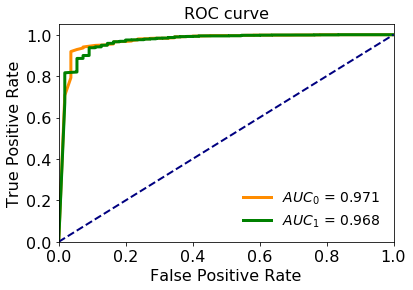

In [37]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [38]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [39]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty', 'Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [ ]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

estimators = [('rf',RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)),
                             ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))]
clf = StackingClassifier( estimators=estimators, final_estimator=MLPClassifier(random_state=0,solver= 'adam', learning_rate_init= 0.01, hidden_layer_sizes=(15)))

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [161]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty', 'Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

AttributeError: 'RandomForestClassifier' object has no attribute 'tree_'

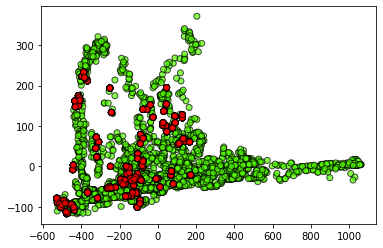

In [45]:
pca = PCA(n_components=2 )
pca.fit(X_train)
X_pca = pca.transform(X_res)
X_test_pca = pca.transform(X_test)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [49]:
pd.Series(y_res).value_counts()

1    3302
0    3302
dtype: int64

Accuracy 0.8829931972789116
F1-score [0.2892562  0.93624907]
              precision    recall  f1-score   support

           0       0.19      0.64      0.29        55
           1       0.98      0.89      0.94      1415

    accuracy                           0.88      1470
   macro avg       0.59      0.76      0.61      1470
weighted avg       0.95      0.88      0.91      1470



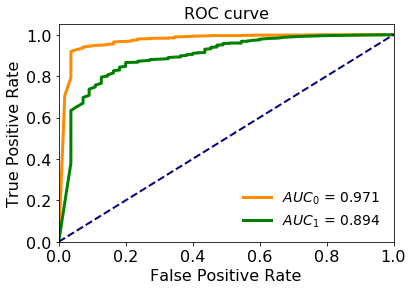

In [33]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)

clf.fit(X_pca, y_res)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test_pca)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

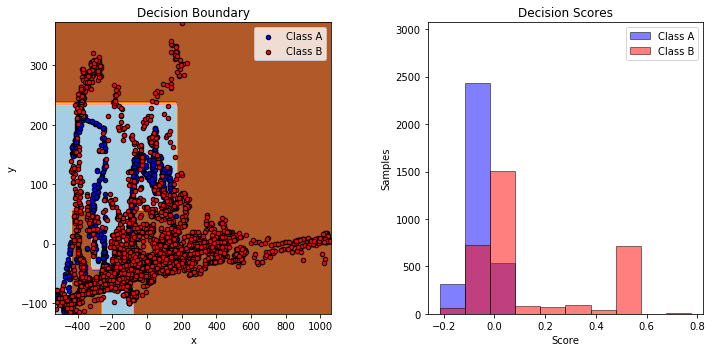

In [34]:
# Author: Noel Dawe <noel.dawe@gmail.com>
#
# License: BSD 3 clause
X=X_pca
y=y_res
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles



# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X_pca, y_res)

plot_colors = "br"
plot_step = 10
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min()-1 , X[:, 0].max()+1 
y_min, y_max = X[:, 1].min() -1, X[:, 1].max() +1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                s=20, edgecolor='k',
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

### SMOTE

In [173]:
svm = SVMSMOTE(random_state=42)
X_res, y_res = svm.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 3302, 0: 3302})


Accuracy 0.9523809523809523
F1-score [0.50704225 0.97498213]
              precision    recall  f1-score   support

           0       0.41      0.65      0.51        55
           1       0.99      0.96      0.97      1415

    accuracy                           0.95      1470
   macro avg       0.70      0.81      0.74      1470
weighted avg       0.96      0.95      0.96      1470



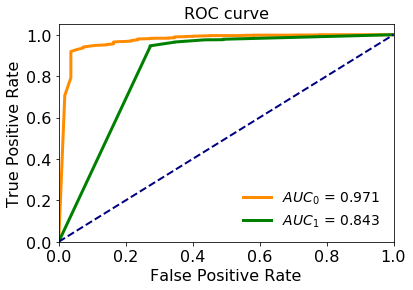

In [174]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9755102040816327
F1-score [0.67857143 0.98727016]
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        55
           1       0.99      0.99      0.99      1415

    accuracy                           0.98      1470
   macro avg       0.83      0.84      0.83      1470
weighted avg       0.98      0.98      0.98      1470



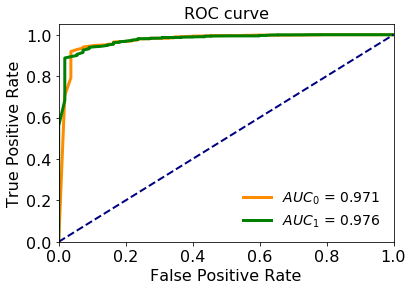

In [175]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9673469387755103
F1-score [0.61290323 0.98295455]
              precision    recall  f1-score   support

           0       0.55      0.69      0.61        55
           1       0.99      0.98      0.98      1415

    accuracy                           0.97      1470
   macro avg       0.77      0.83      0.80      1470
weighted avg       0.97      0.97      0.97      1470



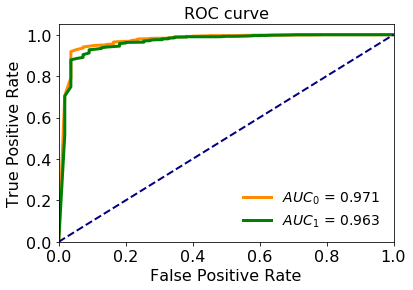

In [183]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)

Accuracy 0.9585034013605442
F1-score [0.57342657 0.97819092]
              precision    recall  f1-score   support

           0       0.47      0.75      0.57        55
           1       0.99      0.97      0.98      1415

    accuracy                           0.96      1470
   macro avg       0.73      0.86      0.78      1470
weighted avg       0.97      0.96      0.96      1470



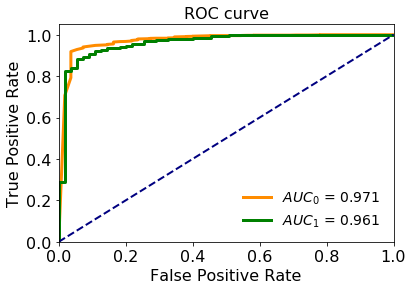

In [185]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier

estimators = [('rf',RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=3, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)),
                             ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))]
final_estimator=MLPClassifier(random_state=0,solver= 'adam', learning_rate_init= 0.01, hidden_layer_sizes=(5))
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)

## ADASYN

In [186]:
from imblearn.over_sampling import ADASYN
adasyn  = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 3302, 0: 3285})


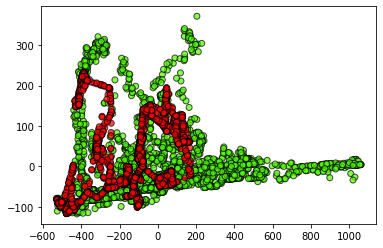

In [187]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_pca = pca.transform(X_res)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_res, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

Accuracy 0.9401360544217687
F1-score [0.39726027 0.96850394]
              precision    recall  f1-score   support

           0       0.32      0.53      0.40        55
           1       0.98      0.96      0.97      1415

    accuracy                           0.94      1470
   macro avg       0.65      0.74      0.68      1470
weighted avg       0.96      0.94      0.95      1470



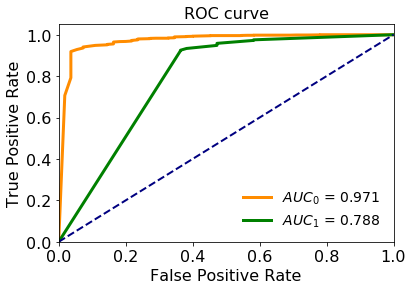

In [188]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

Accuracy 0.9666666666666667
F1-score [0.60162602 0.98260561]
              precision    recall  f1-score   support

           0       0.54      0.67      0.60        55
           1       0.99      0.98      0.98      1415

    accuracy                           0.97      1470
   macro avg       0.77      0.83      0.79      1470
weighted avg       0.97      0.97      0.97      1470



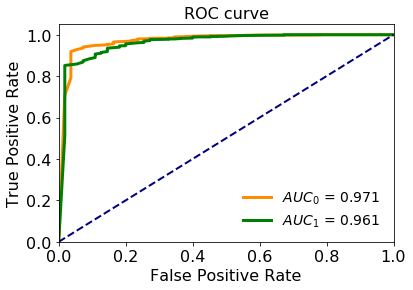

In [189]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, 
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', random_state=0)
clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

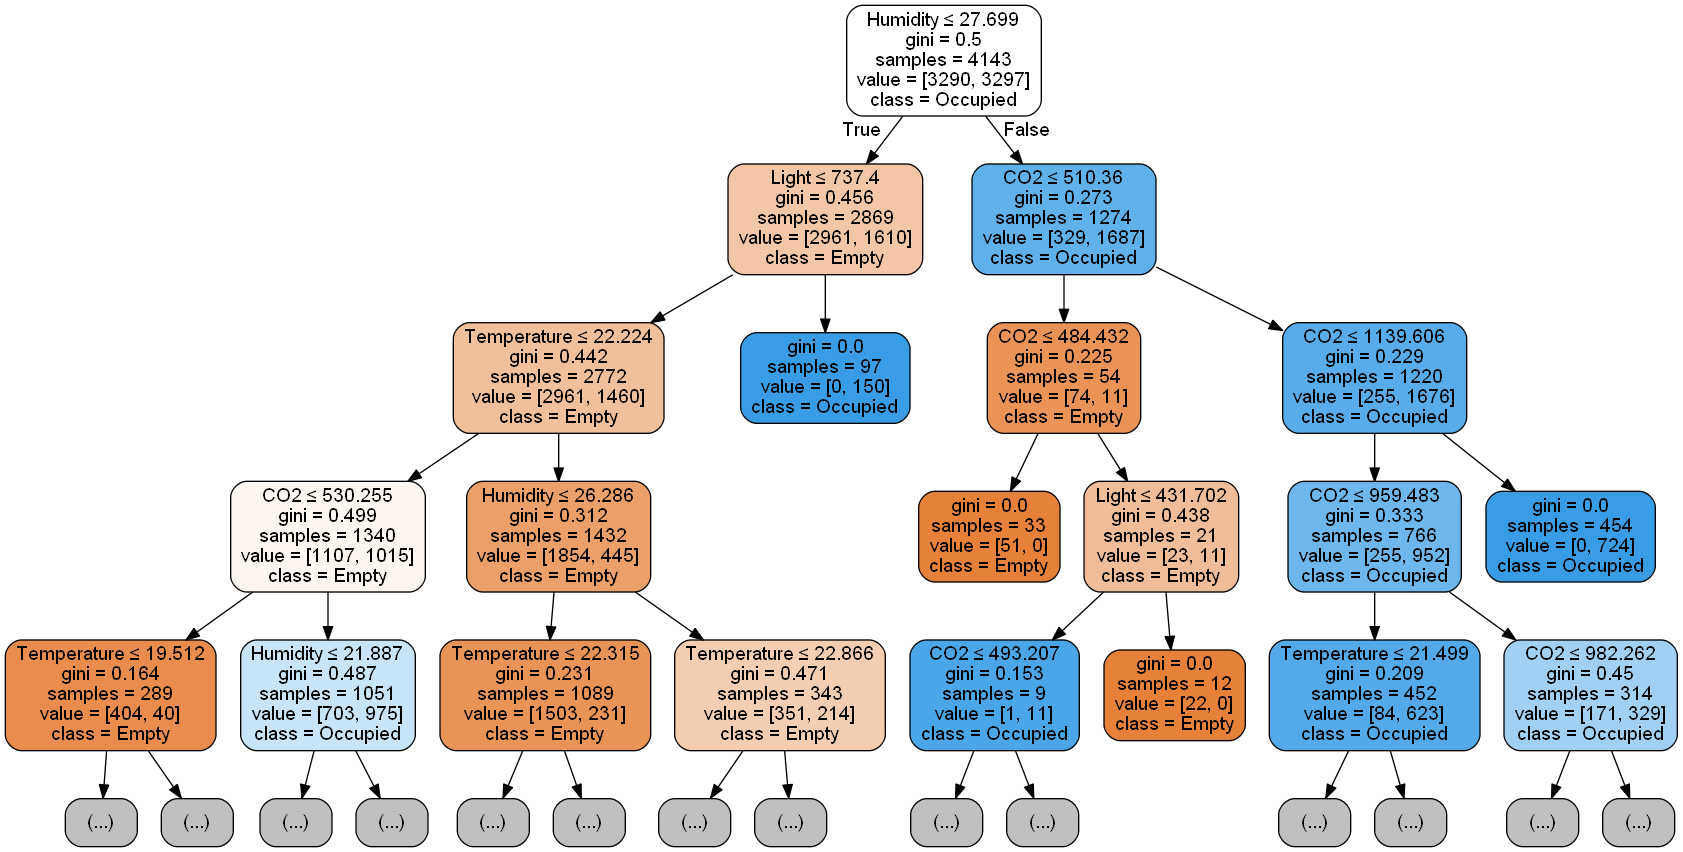

In [180]:
dot_data = tree.export_graphviz(clf.estimators_[0], out_file=None,  
                                feature_names=attributes, 
                                class_names=['Empty','Occupied'],  
                                filled=True, rounded=True,  
                                special_characters=True, max_depth=4)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

Accuracy 0.9673469387755103
F1-score [0.61290323 0.98295455]
              precision    recall  f1-score   support

           0       0.55      0.69      0.61        55
           1       0.99      0.98      0.98      1415

    accuracy                           0.97      1470
   macro avg       0.77      0.83      0.80      1470
weighted avg       0.97      0.97      0.97      1470



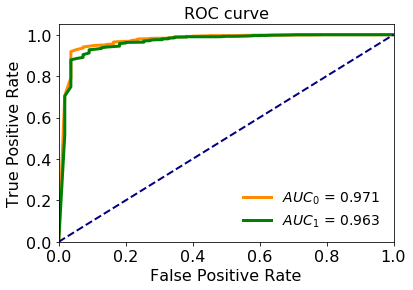

In [181]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=100), n_estimators=100, random_state=0)

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Class Weight 

Accuracy 0.9416157501697217
F1-score [0.43421053 0.96921976]
              precision    recall  f1-score   support

           0       0.34      0.60      0.43        55
           1       0.98      0.95      0.97      1418

    accuracy                           0.94      1473
   macro avg       0.66      0.78      0.70      1473
weighted avg       0.96      0.94      0.95      1473



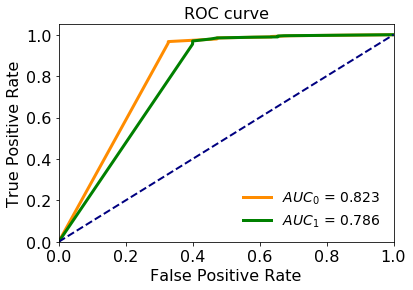

In [216]:
clf = DecisionTreeClassifier(min_samples_leaf=3, class_weight={0:19, 1: 1}, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [269]:
X=X_train
y=y_train
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
RNG = 42
# Make some synthetic imbalanced binary classification data
X, y = make_classification(n_classes=2, class_sep=2, 
    weights=[0.97, 0.03], 
    n_informative=2, n_redundant=5, 
    flip_y=0.05, n_features=50, 
    n_clusters_per_class=1, 
    n_samples=1000, random_state=RNG)

metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
cv = KFold(n_splits=3)
scv = StratifiedKFold(n_splits=3)
clf = RandomForestClassifier()
for metric in metric_names:
    score1 = cross_val_score(clf, X, y, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X, y, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

In [270]:
print(scores_df.T)

                     f1   roc_auc average_precision  accuracy precision  \
Random-CV      0.676363  0.734749          0.582429  0.974993  0.952381   
Stratified-CV  0.702564  0.752885          0.581961  0.972991   0.87963   

                 recall  
Random-CV      0.546366  
Stratified-CV  0.555556  


In [272]:
scores_df

,Random-CV,Stratified-CV
f1,0.676363,0.702564
roc_auc,0.734749,0.752885
average_precision,0.582429,0.581961
accuracy,0.974993,0.972991
precision,0.952381,0.87963
recall,0.546366,0.555556


# Meta-Cost Sensitive Classifier

In [217]:

from costcla.models import CostSensitiveDecisionTreeClassifier
from costcla.metrics import savings_score

cost_mat : array-like of shape = [n_samples, 4]

Cost matrix of the classification problem Where the columns represents the costs of: false positives, false negatives, true positives and true negatives, for each example.

In [218]:
attributes = ['Temperature', 'Humidity', 'Light', 'CO2']

X_train =training[attributes].copy()
y_train=training[['Occupancy']].values
X_test=test[attributes].copy()
y_test=test[['Occupancy']].values

In [219]:
cost = [1, 10, 1, 1]
cost_mat = np.array([cost] * len(X_train))
cost_mat.shape

(3434, 4)

In [220]:
cost_mat 

array([[ 1, 10,  1,  1],
       [ 1, 10,  1,  1],
       [ 1, 10,  1,  1],
       ...,
       [ 1, 10,  1,  1],
       [ 1, 10,  1,  1],
       [ 1, 10,  1,  1]])

In [224]:
cost = [1, 10, 1, 1]
cost = np.array(cost)

In [225]:
y_train.shape

(3434, 1)

In [226]:
clf = CostSensitiveDecisionTreeClassifier()
clf.fit(X_train, y_train, cost)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot(fpr, tpr, color='green', lw=3, label='$AUC_1$ = %.3f' % (roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

IndexError: too many indices for array

In [50]:
cost_mat_test = np.array([cost] * len(X_test))
print(savings_score(y_test, y_pred, cost_mat_test))
print(savings_score(y_test, y_pred0, cost_mat_test))

0.17333333333333334
0.22666666666666668


# Scikit-plot

In [51]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve

In [52]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.932
F1-score [0.96046512 0.75714286]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       855
           1       0.79      0.73      0.76       145

    accuracy                           0.93      1000
   macro avg       0.87      0.85      0.86      1000
weighted avg       0.93      0.93      0.93      1000



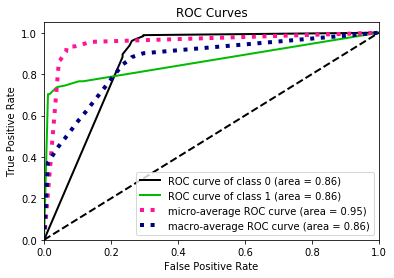

In [53]:
plot_roc(y_test, y_score)
plt.show()

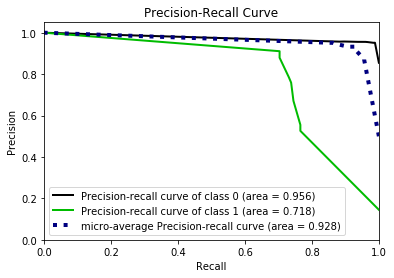

In [54]:
plot_precision_recall(y_test, y_score)
plt.show()

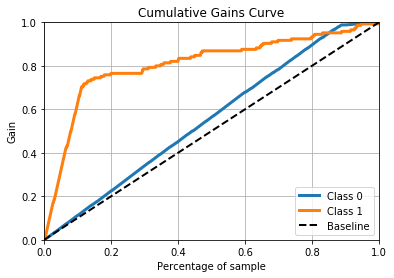

In [55]:
plot_cumulative_gain(y_test, y_score)
plt.show()

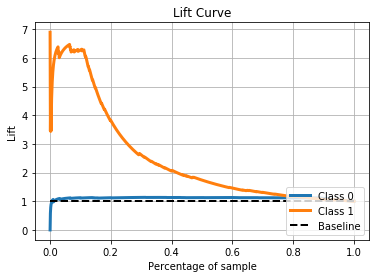

In [56]:
plot_lift_curve(y_test, y_score)
plt.show()